In [177]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import dateutil.parser
from scipy.optimize import minimize
from sklearn.cluster import DBSCAN

import time
from datetime import datetime, timedelta

# Let's calculate the probability of another earthquake happen in JP in this year

In [101]:
def clean_data(df):
    df_clean = df.copy()
    
    # Initialize geocoder
    geolocator = Nominatim(user_agent="earthquake_analysis")
    
    # Extract latitude and longitude
    def extract_coordinates(epicenter_str):
        if pd.isna(epicenter_str):
            return np.nan, np.nan
        
        # Case 1: Standard format with degrees and minutes
        pattern1 = r"(\d+)°(\d+)′N\s+(\d+)°(\d+)′E"
        match1 = re.search(pattern1, str(epicenter_str))
        if match1:
            lat_deg, lat_min, lon_deg, lon_min = map(float, match1.groups())
            lat = lat_deg + lat_min/60
            lon = lon_deg + lon_min/60
            return lat, lon
        
        # Case 2: Decimal degrees format
        pattern2 = r"(\d+\.\d+)°N\s+(\d+\.\d+)°E"
        match2 = re.search(pattern2, str(epicenter_str))
        if match2:
            lat, lon = map(float, match2.groups())
            return lat, lon
        
        # Case 3: Decimal degrees with additional info (depth, etc.)
        pattern3 = r"(\d+\.\d+)°N\s+(\d+\.\d+)°E.*?(?:depth|km)"
        match3 = re.search(pattern3, str(epicenter_str))
        if match3:
            lat, lon = map(float, match3.groups())
            return lat, lon
        
        # Case 4: Extract coordinates from mixed format
        pattern4 = r"(\d+\.\d+)[°N]\s*(?:,|;|\s)\s*(\d+\.\d+)[°E]"
        match4 = re.search(pattern4, str(epicenter_str))
        if match4:
            lat, lon = map(float, match4.groups())
            return lat, lon
        
        # Case 5: For locations without coordinates, use geocoding
        # Extract location names (ignoring distances like "50 miles from")
        location_name = None
        
        # Try to extract place names
        place_patterns = [
            r"near\s+([A-Za-z\s,]+?)(?:\s*,|\s*$)",
            r"offshore\s+([A-Za-z\s,]+?)(?:\s*,|\s*$)",
            r"(\w+\s+Prefecture)",
            r"(\w+\s+Island[s]?)",
            r"([A-Za-z]+\s+Bay)",
            r"(\w+,\s*Japan)"
        ]
        
        for pattern in place_patterns:
            match = re.search(pattern, str(epicenter_str))
            if match:
                location_name = match.group(1).strip()
                break
        
        # If no match with patterns, use the whole string as location
        if not location_name and not any(x in str(epicenter_str).lower() for x in ["°n", "°e"]):
            # Clean up distances and directions
            location = re.sub(r'\d+\s*km\s*(?:north|south|east|west|ne|nw|se|sw|nnw|sse|etc).*?of', '', str(epicenter_str))
            location = re.sub(r'\d+\s*miles.*?from', '', location)
            location_name = location.strip()
        
        # If location name found, try geocoding
        if location_name:
            try:
                # Add Japan to improve geocoding accuracy
                if "Japan" not in location_name:
                    search_term = f"{location_name}, Japan"
                else:
                    search_term = location_name
                
                location = geolocator.geocode(search_term, timeout=10)
                if location:
                    return location.latitude, location.longitude
                
                # Retry with simplified location if failed
                simplified = re.sub(r'[(),]', '', location_name)
                if simplified != location_name:
                    location = geolocator.geocode(f"{simplified}, Japan", timeout=10)
                    if location:
                        return location.latitude, location.longitude
                
                # Rate limiting to avoid timeout errors
                time.sleep(1)
            except (GeocoderTimedOut, GeocoderUnavailable):
                time.sleep(2)  # Wait longer if timed out
        
        return np.nan, np.nan
    
    # Apply coordinate extraction with error handling
    coordinates_list = []
    for idx, row in df_clean.iterrows():
        try:
            lat, lon = extract_coordinates(row['Epicenter'])
            coordinates_list.append((lat, lon))
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            coordinates_list.append((np.nan, np.nan))
    
    # Convert list to DataFrame columns
    df_clean['Latitude'] = [coord[0] for coord in coordinates_list]
    df_clean['Longitude'] = [coord[1] for coord in coordinates_list]
    
    # Parse full datetime
    def parse_datetime(date_str):
        if pd.isna(date_str):
            return np.nan, np.nan
        
        date_str = str(date_str)
        
        # Modern format with full datetime (e.g., "January 1, 2024 16:10:09 JST")
        modern_pattern = r"([A-Za-z]+\s+\d{1,2},\s+\d{4})\s+(\d{1,2}:\d{2}:\d{2})\s+([A-Z]+)"
        modern_match = re.search(modern_pattern, date_str)
        if modern_match:
            date_part, time_part, timezone = modern_match.groups()
            try:
                # Convert to datetime
                dt = dateutil.parser.parse(f"{date_part} {time_part}")
                # Add timezone info
                timezone_str = timezone
                return dt, timezone_str
            except:
                pass  # Fall through to other patterns if this fails
        
        # Format with date and time but no timezone (e.g., "March 11, 2011 05:46:23")
        datetime_pattern = r"([A-Za-z]+\s+\d{1,2},\s+\d{4})\s+(\d{1,2}:\d{2}:\d{2})"
        datetime_match = re.search(datetime_pattern, date_str)
        if datetime_match:
            date_part, time_part = datetime_match.groups()
            try:
                dt = dateutil.parser.parse(f"{date_part} {time_part}")
                return dt, "Unknown"
            except:
                pass
        
        # Format with just date (e.g., "March 11, 2011")
        date_only_pattern = r"([A-Za-z]+\s+\d{1,2},\s+\d{4})"
        date_only_match = re.search(date_only_pattern, date_str)
        if date_only_match:
            try:
                dt = dateutil.parser.parse(date_only_match.group(1))
                return dt, "Unknown"
            except:
                pass
        
        # For historical dates with year only or year and month
        year_pattern = r"(\d{3,4})"
        year_match = re.search(year_pattern, date_str)
        if year_match:
            year = int(year_match.group(1))
            # Check if month is also present
            month_pattern = r"([A-Za-z]+)\s+\d{3,4}"
            month_match = re.search(month_pattern, date_str)
            if month_match:
                month_name = month_match.group(1)
                try:
                    month_num = {
                        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
                    }[month_name]
                    return datetime(year, month_num, 1), "Unknown"
                except:
                    return datetime(year, 1, 1), "Unknown"
            else:
                return datetime(year, 1, 1), "Unknown"
        
        return np.nan, np.nan
    
    # Apply datetime parsing
    datetime_results = df_clean['Date and time'].apply(parse_datetime)
    df_clean['Datetime'] = [result[0] for result in datetime_results]
    df_clean['Timezone'] = [result[1] for result in datetime_results]
    
    # Extract year from the datetime for convenience
    df_clean['Year'] = df_clean['Datetime'].apply(lambda x: x.year if pd.notnull(x) else np.nan)
    
    # Standardize magnitude
    def standardize_magnitude(mag_str):
        if pd.isna(mag_str):
            return np.nan
        match = re.search(r'([\d.]+)', str(mag_str))
        if not match:
            return np.nan
        magnitude = float(match.group(1))
        if 'MK' in str(mag_str):
            return magnitude * 0.95
        elif 'Ms' in str(mag_str):
            return 0.99 * magnitude - 0.08
        elif 'ML' in str(mag_str):
            return 0.85 * magnitude + 1.03
        return magnitude
    
    df_clean['Magnitude'] = df_clean['Magnitude'].apply(standardize_magnitude)
    
    # Handle fatalities
    def parse_fatalities(fatality_str):
        if pd.isna(fatality_str):
            return 0
        if isinstance(fatality_str, (int, float)):
            return fatality_str
        match = re.search(r'(\d+)', str(fatality_str))
        if match:
            return int(match.group(1))
        if '+' in str(fatality_str):
            match = re.search(r'(\d+)\+', str(fatality_str))
            if match:
                return int(match.group(1))
        return 0
    
    df_clean['Fatalities'] = df_clean['Fatalities'].apply(parse_fatalities)
    
    # Extract depth information where available
    def extract_depth(epicenter_str):
        if pd.isna(epicenter_str):
            return np.nan
        
        depth_pattern = r'(\d+(?:\.\d+)?)\s*km\s*depth'
        match = re.search(depth_pattern, str(epicenter_str))
        if match:
            return float(match.group(1))
        return np.nan
    
    df_clean['Depth_km'] = df_clean['Epicenter'].apply(extract_depth)
    
    # Drop rows with missing critical data
    df_clean = df_clean.dropna(subset=['Year', 'Magnitude'])
    
    # Create decade feature
    df_clean['Decade'] = (df_clean['Year'] // 10) * 10
    
    # Create binary target for significant earthquakes (M ≥ 7.0)
    df_clean['Significant'] = (df_clean['Magnitude'] >= 7.0).astype(int)
    
    # Keep only processed columns
    df_clean = df_clean[['Datetime', 'Timezone', 'Year', 'Decade', 'Magnitude', 'Fatalities', 'Latitude', 'Longitude', 'Depth_km', 'Significant']]
    
    return df_clean

# Apply the cleaning function
EQ_clean = clean_data(EQ_history)

In [102]:
EQ_history = pd.read_html('https://en.wikipedia.org/wiki/List_of_earthquakes_in_Japan')[1]
EQ_clean = clean_data(EQ_history)

In [103]:
EQ_clean.tail(2) # seems right

,Datetime,Timezone,Year,Decade,Magnitude,Fatalities,Latitude,Longitude,Depth_km,Significant
97,2024-01-01 16:10:09,JST,2024,2020,7.5,572,37.498,137.242,10.0,1
98,2024-08-08 16:42:55,JST,2024,2020,7.1,0,31.719,131.527,25.0,1


In [119]:
EQ_history.tail(2)

,Date and time,Magnitude,Fatalities,Name of quake,Name in Kanji,Rōmaji name,Epicenter,Description
97,"January 1, 2024 16:10:09 JST",7.5 Mw,572,2024 Noto earthquake,能登半島地震,Reiwa 6-nen Notohanto Jishin,37°29′53″N 137°14′31″E﻿ / ﻿37.498°N 137.242°E ...,42 km NE of Anamizu
98,"August 8, 2024 16:42:55 JST",7.1 Mw,0,2024 Hyūga-nada earthquake,日向灘地震,Hyūga-nada Jishin,31°43′08″N 131°31′37″E﻿ / ﻿31.719°N 131.527°E ...,25 km NE of Nichinan


# Hawkes Process

## Self-Exciting Point Process
A Hawkes process is a variation of Poisson process

Occurrence of shock increases the probability of future (after)shock temporarily.

The event intensity(probability) $\lambda(t)$ can be written as
$$
\lambda(t) = \mu + \sum \alpha e^{-\beta(t-t_i)}
$$
where
* $\mu$ : Background rate (independent earthquake occurrence
* $\alpha$: Excitation parameter (how much an event increases future probability)
* $\beta$: Decay parameter (how quickly the increased probability fades)
* $t_i$: Time of previous events

## Assumption
* Uniform decay rate for all earthquakes($e^{-t}$)
* Ignore fault geometry or stress transfer mechanics

## Spatial Grouping
* Divides Japan into regions based on latitude bands
* Allows region-specific parameter estimation to account for different seismic characteristics

In [ ]:
def hawkes_intensity(t, events, alpha, beta, mu):
    if not isinstance(t, np.ndarray):
        t = np.array([t])
    
    intensity = np.full_like(t, mu, dtype=float)
    
    for event_time in events:
        mask = t > event_time
        if np.any(mask):
            intensity[mask] += alpha * np.exp(-beta * (t[mask] - event_time))
    
    return intensity

def hawkes_log_likelihood(params, event_times, end_time):
    mu, alpha, beta = params
    
    if mu <= 0 or alpha <= 0 or beta <= 0 or alpha >= beta:
        return np.inf
    
    log_likelihood = 0
    
    for i, t in enumerate(event_times):
        past_events = event_times[:i]
        intensity = hawkes_intensity(t, past_events, alpha, beta, mu)
        log_likelihood += np.log(intensity[0])
    
    log_likelihood -= mu * end_time
    
    for i, t_i in enumerate(event_times):
        remaining_time = end_time - t_i
        log_likelihood -= alpha * (1 - np.exp(-beta * remaining_time)) / beta
    
    return -log_likelihood

def fit_hawkes_process(event_times):
    event_times = np.sort(event_times)
    end_time = event_times[-1] + 0.01
    
    initial_mu = len(event_times) / end_time * 0.5
    initial_alpha = initial_mu
    initial_beta = 2 * initial_alpha
    
    initial_params = [initial_mu, initial_alpha, initial_beta]
    
    result = minimize(
        hawkes_log_likelihood,
        initial_params,
        args=(event_times, end_time),
        method='L-BFGS-B',
        bounds=[(1e-10, None), (1e-10, None), (1e-10, None)]
    )
    
    mu, alpha, beta = result.x
    R = alpha / beta
    
    return {
        'mu': mu,
        'alpha': alpha,
        'beta': beta,
        'R0': R,
        'n_events': len(event_times),
        'success': result.success
    }

We will just fit the data using Maximum Likelihood

In [183]:
def model_earthquakes_with_hawkes(df):
    df = df.sort_values('Datetime').reset_index(drop=True)
    
    base_date = datetime(1, 1, 1)
    df['Time_Decimal'] = df['Datetime'].apply(
        lambda x: (x - base_date).total_seconds() / (365.25 * 24 * 3600) if pd.notnull(x) else np.nan
    )
    
    df_valid = df.dropna(subset=['Time_Decimal']).copy()
    min_time = df_valid['Time_Decimal'].min()
    df_valid['Time_Normalized'] = df_valid['Time_Decimal'] - min_time
    
    # Region info dictionary to store geographic details
    region_info = {}
    
    # Simplified region assignment with geographic naming
    if not df_valid.empty and 'Latitude' in df_valid.columns and 'Longitude' in df_valid.columns:
        valid_coords = df_valid.dropna(subset=['Latitude', 'Longitude'])
        if len(valid_coords) > 5:
            # Create simple grid-based regions (coarse)
            df_valid['Region'] = -1
            
            # Divide Japan into regions with descriptive names
            region_definitions = [
                {"name": "Southern Japan", "lat_range": (30, 35)},
                {"name": "Central Japan", "lat_range": (35, 40)},
                {"name": "Northern Japan", "lat_range": (40, 45)}
            ]
            
            for i, region_def in enumerate(region_definitions):
                lat_min, lat_max = region_def["lat_range"]
                mask = (df_valid['Latitude'] >= lat_min) & (df_valid['Latitude'] < lat_max)
                df_valid.loc[mask, 'Region'] = i
                
                # Calculate mean coordinates for this region
                region_data = df_valid[mask]
                if len(region_data) > 0:
                    mean_lat = region_data['Latitude'].mean()
                    mean_lon = region_data['Longitude'].mean()
                    region_info[i] = {
                        "name": region_def["name"],
                        "mean_lat": mean_lat,
                        "mean_lon": mean_lon,
                        "lat_range": (lat_min, lat_max),
                        "n_events": len(region_data)
                    }
            
            # Handle rows with no assigned region (outside defined ranges)
            other_mask = df_valid['Region'] == -1
            df_valid.loc[other_mask, 'Region'] = len(region_definitions)
            
            # Calculate mean for "Other" region
            other_data = df_valid[other_mask]
            if len(other_data) > 0:
                mean_lat = other_data['Latitude'].mean()
                mean_lon = other_data['Longitude'].mean()
                region_info[len(region_definitions)] = {
                    "name": "Other Japan Regions",
                    "mean_lat": mean_lat,
                    "mean_lon": mean_lon,
                    "lat_range": (other_data['Latitude'].min(), other_data['Latitude'].max()),
                    "n_events": len(other_data)
                }
        else:
            df_valid['Region'] = 0
            # Single region for all Japan
            mean_lat = valid_coords['Latitude'].mean() if 'Latitude' in valid_coords else np.nan
            mean_lon = valid_coords['Longitude'].mean() if 'Longitude' in valid_coords else np.nan
            region_info[0] = {
                "name": "All Japan",
                "mean_lat": mean_lat,
                "mean_lon": mean_lon,
                "lat_range": (valid_coords['Latitude'].min(), valid_coords['Latitude'].max()),
                "n_events": len(valid_coords)
            }
    else:
        df_valid['Region'] = 0
        region_info[0] = {
            "name": "All Japan",
            "mean_lat": np.nan,
            "mean_lon": np.nan,
            "lat_range": (np.nan, np.nan),
            "n_events": len(df_valid)
        }
    
    regions = df_valid['Region'].unique()
    
    model_results = {}
    fig, axes = plt.subplots(len(regions), 1, figsize=(12, 4 * len(regions)))
    if len(regions) == 1:
        axes = [axes]
    
    for i, region in enumerate(regions):
        region_data = df_valid[df_valid['Region'] == region]
        
        # Lower minimum samples required
        if len(region_data) < 5:
            print(f"Not enough data for region {region}, skipping.")
            continue
        
        event_times = region_data['Time_Normalized'].values
        end_time = event_times[-1] + 0.1
        
        try:
            params = fit_hawkes_process(event_times)
            
            mu = params['mu']
            alpha = params['alpha']
            beta = params['beta']
            
            # Add region info to parameters
            params.update(region_info.get(region, {"name": f"Region {region}"}))
            model_results[region] = params
            
            times = np.linspace(0, end_time, 1000)
            intensity = hawkes_intensity(times, event_times, alpha, beta, mu)
            
            ax = axes[i]
            ax.plot(times, intensity, 'r-', label='Intensity')
            ax.vlines(event_times, 0, 0.1, alpha=0.2, color='b', linewidth=1)
            
            magnitude_scale = 50
            scatter = ax.scatter(
                event_times, 
                np.ones_like(event_times) * 0.05,
                s=region_data['Magnitude'].values * magnitude_scale,
                alpha=0.7, 
                c=region_data['Magnitude'].values,
                cmap='viridis'
            )
            
            plt.colorbar(scatter, ax=ax, label='Magnitude')
            
            # Use region name in title
            region_name = region_info.get(region, {}).get("name", f"Region {region}")
            mean_coords = ""
            if "mean_lat" in params and "mean_lon" in params:
                if not np.isnan(params["mean_lat"]) and not np.isnan(params["mean_lon"]):
                    mean_coords = f" (~{params['mean_lat']:.2f}°N, {params['mean_lon']:.2f}°E)"
            
            ax.set_title(f'{region_name}{mean_coords}: μ={mu:.5f}, α={alpha:.2f}, β={beta:.2f}, R₀={alpha/beta:.2f}')
            ax.set_xlabel('Time (years since first event)')
            ax.set_ylabel('Intensity')
            ax.grid(True, alpha=0.3)
            
            xticks = ax.get_xticks()
            years = [int(min_time + x) for x in xticks if x >= 0 and x <= end_time]
            ax.set_xticks([y - min_time for y in years])
            ax.set_xticklabels(years)
            
        except Exception as e:
            print(f"Error fitting Hawkes process for region {region}: {e}")
    
    plt.tight_layout()
    
    # Identify aftershock sequences
    aftershock_sequences = []
    
    for region, params in model_results.items():
        region_data = df_valid[df_valid['Region'] == region].copy()
        if len(region_data) < 2:
            continue
            
        alpha = params['alpha']
        beta = params['beta']
        region_name = params.get("name", f"Region {region}")
        
        # Track sequences
        for i in range(len(region_data)-1):
            mainshock = region_data.iloc[i]
            mainshock_time = mainshock['Time_Normalized']
            mainshock_mag = mainshock['Magnitude']
            
            # Only consider significant earthquakes as mainshocks
            if mainshock_mag < 6.0:
                continue
                
            # Get coordinates of mainshock if available
            mainshock_lat = mainshock.get('Latitude', np.nan)
            mainshock_lon = mainshock.get('Longitude', np.nan)
                
            # Find potential aftershocks
            aftershocks = []
            for j in range(i+1, len(region_data)):
                aftershock = region_data.iloc[j]
                time_diff = aftershock['Time_Normalized'] - mainshock_time
                
                # Using Omori's law to determine aftershocks
                if time_diff <= 1.0:  # Within 1 year
                    # Calculate triggering probability
                    trigger_prob = alpha * np.exp(-beta * time_diff) * (np.exp(mainshock_mag - 5.0))
                    background_prob = params['mu']
                    
                    # If triggering component exceeds background, likely an aftershock
                    if trigger_prob > background_prob:
                        # Include coordinates if available
                        aftershock_info = (
                            aftershock['Datetime'], 
                            aftershock['Magnitude'],
                            aftershock.get('Latitude', np.nan),
                            aftershock.get('Longitude', np.nan)
                        )
                        aftershocks.append(aftershock_info)
                    else:
                        # New mainshock - stop this sequence
                        break
                else:
                    # Too much time passed
                    break
            
            # Record sequence if it has aftershocks
            if aftershocks:
                aftershock_sequences.append({
                    'region': region,
                    'region_name': region_name,
                    'mainshock_time': mainshock['Datetime'],
                    'mainshock_magnitude': mainshock_mag,
                    'mainshock_lat': mainshock_lat,
                    'mainshock_lon': mainshock_lon,
                    'n_aftershocks': len(aftershocks),
                    'aftershocks': aftershocks,
                    'duration_days': (aftershocks[-1][0] - mainshock['Datetime']).total_seconds() / (24*3600)
                })
    
    return {
        'model_params': model_results,
        'aftershock_sequences': aftershock_sequences,
        'plot_figure': fig,
        'region_info': region_info
    }

# Print summary with enhanced regional information
print("\nHawkes Process Model Parameters by Region:")
for region, params in hawkes_results['model_params'].items():
    region_name = params.get("name", f"Region {region}")
    location_str = ""
    if "mean_lat" in params and "mean_lon" in params:
        if not np.isnan(params["mean_lat"]) and not np.isnan(params["mean_lon"]):
            location_str = f" (center: {params['mean_lat']:.2f}°N, {params['mean_lon']:.2f}°E)"
    
    print(f"\n{region_name}{location_str}:")
    print(f"  Background rate (μ): {params['mu']:.6f} earthquakes per year")
    print(f"  Excitation factor (α): {params['alpha']:.4f}")
    print(f"  Decay rate (β): {params['beta']:.4f}")
    print(f"  Reproduction number (R₀): {params['R0']:.4f}")
    print(f"  Number of events: {params['n_events']}")
    
    if "lat_range" in params:
        print(f"  Latitude range: {params['lat_range'][0]:.2f}° to {params['lat_range'][1]:.2f}°N")


Hawkes Process Model Parameters by Region:

Southern Japan (center: 33.92°N, 135.16°E):
  Background rate (μ): 0.008578 earthquakes per year
  Excitation factor (α): 0.0086
  Decay rate (β): 0.0172
  Reproduction number (R₀): 0.5000
  Number of events: 23
  Latitude range: 30.00° to 35.00°N

Central Japan (center: 37.48°N, 140.47°E):
  Background rate (μ): 0.014179 earthquakes per year
  Excitation factor (α): 0.0142
  Decay rate (β): 0.0284
  Reproduction number (R₀): 0.5000
  Number of events: 38
  Latitude range: 35.00° to 40.00°N

Other Japan Regions (center: 28.90°N, 136.05°E):
  Background rate (μ): 0.010884 earthquakes per year
  Excitation factor (α): 0.0109
  Decay rate (β): 0.0218
  Reproduction number (R₀): 0.5000
  Number of events: 29
  Latitude range: 22.30° to 46.48°N

Northern Japan (center: 42.28°N, 143.00°E):
  Background rate (μ): 0.003372 earthquakes per year
  Excitation factor (α): 0.0034
  Decay rate (β): 0.0067
  Reproduction number (R₀): 0.5000
  Number of eve

/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


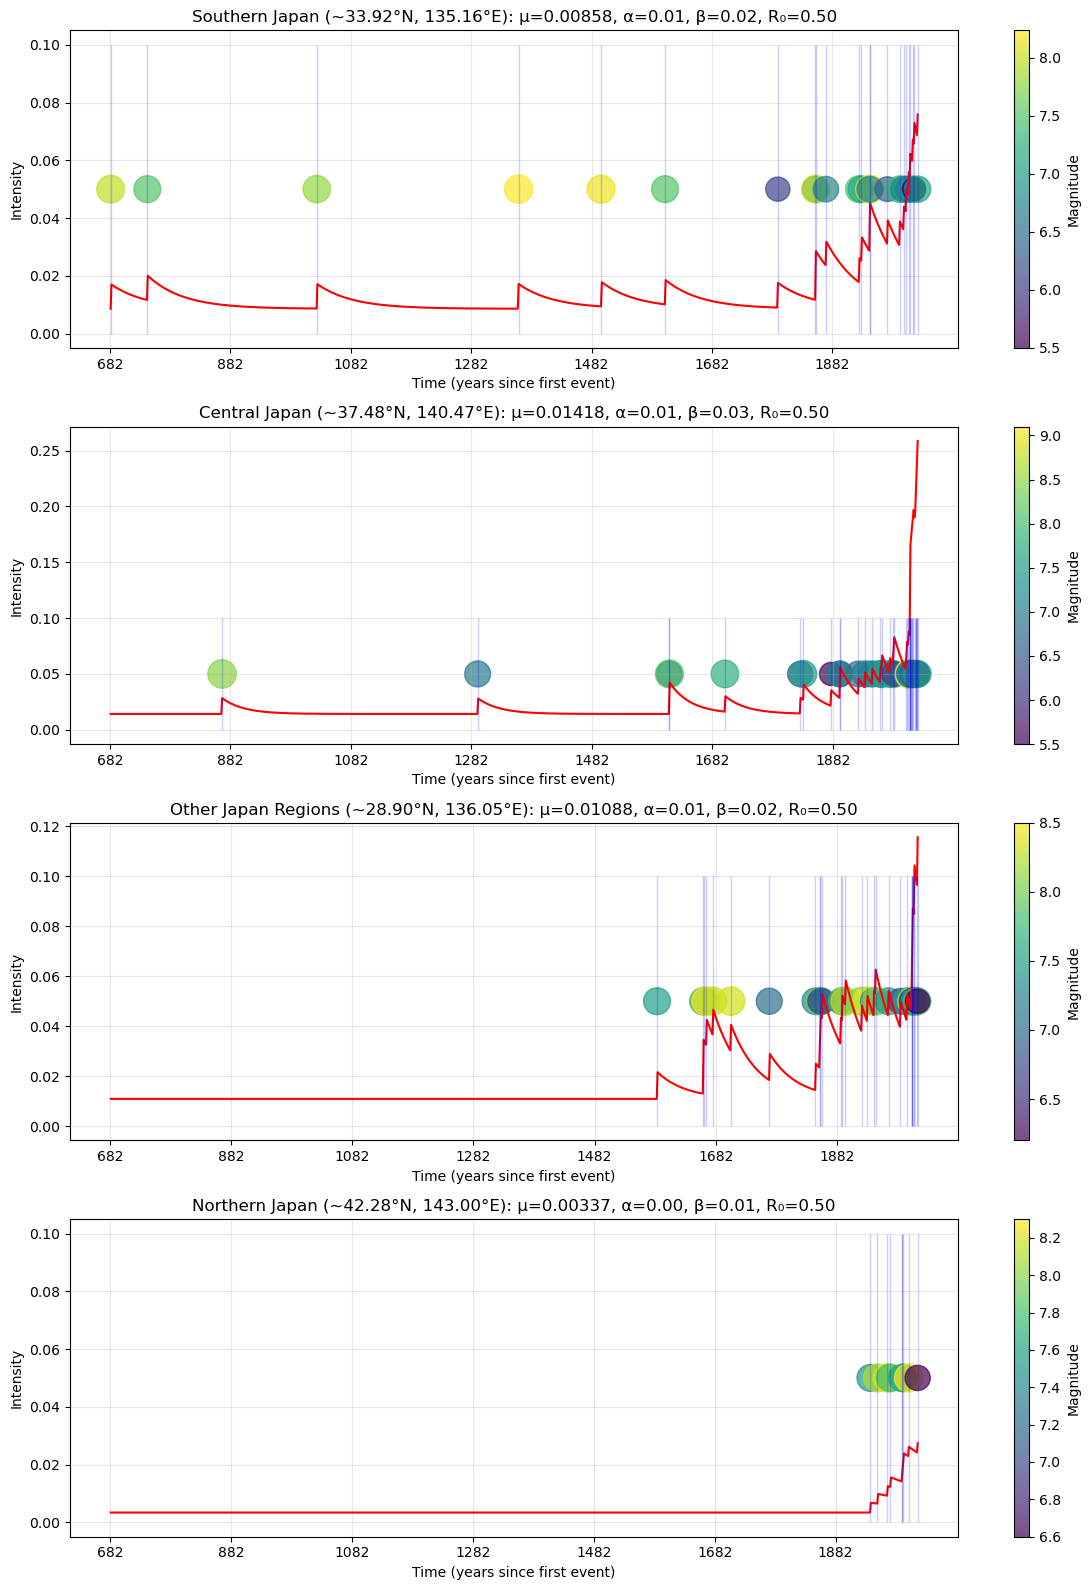

In [185]:
hawkes_results = model_earthquakes_with_hawkes(EQ_clean)

In [201]:
print("\nHawkes Process Model Parameters:")
for region, params in hawkes_results['model_params'].items():
    print(f"Region {hawkes_results['region_info'][region]['name']}:")
    print(f"  Background rate (μ): {params['mu']:.6f}")
    print(f"  Excitation factor (α): {params['alpha']:.4f}")
    print(f"  Decay rate (β): {params['beta']:.4f}")
    print(f"  Reproduction number (R₀): {params['R0']:.4f}")
    print(f"  Number of events: {params['n_events']}")
    print()

print("\nIdentified Aftershock Sequences:")
for i, seq in enumerate(hawkes_results['aftershock_sequences']):
    print(f"Sequence {i+1}:")
    print(f"  Mainshock: {seq['mainshock_time']} (M{seq['mainshock_magnitude']:.1f})")
    print(f"  Aftershocks: {seq['n_aftershocks']}")
    print(f"  Duration: {seq['duration_days']:.1f} days")
    print()


Hawkes Process Model Parameters:
Region Southern Japan:
  Background rate (μ): 0.008578
  Excitation factor (α): 0.0086
  Decay rate (β): 0.0172
  Reproduction number (R₀): 0.5000
  Number of events: 23

Region Central Japan:
  Background rate (μ): 0.014179
  Excitation factor (α): 0.0142
  Decay rate (β): 0.0284
  Reproduction number (R₀): 0.5000
  Number of events: 38

Region Other Japan Regions:
  Background rate (μ): 0.010884
  Excitation factor (α): 0.0109
  Decay rate (β): 0.0218
  Reproduction number (R₀): 0.5000
  Number of events: 29

Region Northern Japan:
  Background rate (μ): 0.003372
  Excitation factor (α): 0.0034
  Decay rate (β): 0.0067
  Reproduction number (R₀): 0.5000
  Number of events: 9


Identified Aftershock Sequences:
Sequence 1:
  Mainshock: 1854-07-09 00:00:00 (M6.9)
  Aftershocks: 1
  Duration: 167.0 days

Sequence 2:
  Mainshock: 1944-12-07 00:00:00 (M8.1)
  Aftershocks: 1
  Duration: 37.0 days

Sequence 3:
  Mainshock: 1611-09-27 00:00:00 (M6.6)
  Afters

# Hazard function

We can use the intensity to compute the hazard function. First the intensity is

$$
\lambda(t) = \mu + \sum_{i:t_i<t} \alpha e^{M_i-M_0}e^{-\beta(t-t_i)}
$$

where
* $M_i$ is the magnitude of earthquake i
* $M_0$ is a reference magnitude (usually 5.0, but we will use the min of that region)

Then the daily hazard can be computed
$$
\lambda_\mathrm{daily}(t) = \lambda(t)/365.25
$$
The daily probability of at least one earthquake occurring on day t, given no earthquakes up to that point, is the hazard function
$$
H(t) = 1 - e^{-\lambda_\mathrm{daily}(t)}
$$
(Poisson probability)

# Gutenberg-Richter relationship
For a specific magnitude threshold $M_{\text{threshold}}$, we use the Gutenberg-Richter relationship, which states that earthquake frequency decreases exponentially with magnitude

$$
\mathrm{log}_{10} N(M) = a - b M
$$

Where:
* $N(M)$ is the number of earthquakes with magnitude ≥ M
* $a$ and $b$ are constants ($b \approx 1$)

the probability that an earthquake exceeds magnitude $M_{\text{threshold}}$, given that an earthquake occurs
$$
P(M \geq M_\mathrm{threshold}∣\mathrm{earthquake}) = 10^{-b (M_\mathrm{threshold} - M_\mathrm{min})}
$$
where
* $M_{\text{min}}$ is the minimum magnitude in the dataset.

# Cummulative probability
Now, the probability of a earthquake happen with magnitude that greater than $M_\mathrm{threshold}$ in day t is
$$
P(M \geq M_\mathrm{threshold}, \mathrm{at} \ t) = P(M \geq M_\mathrm{threshold}∣\mathrm{earthquake}) \times H(t)
$$
Thus, the cummulative probability is
$$
P(M \geq M_\mathrm{threshold}, \mathrm{within} \ T) = 1 - \prod_{i=1}^T (1- P(M \geq M_\mathrm{threshold}, \mathrm{at} \ t))
$$

In [255]:
def plot_earthquake_probabilities(hawkes_results, EQ_clean, future_days=730):
    """
    Plot cumulative earthquake probabilities and generate probability table.
    """
    def calculate_earthquake_hazard(params, region_data, future_days=730, magnitude_threshold=6.0):
        mu = params['mu']
        alpha = params['alpha']
        beta = params['beta']
        
        if 'Time_Normalized' not in region_data.columns:
            base_date = datetime(1, 1, 1)
            region_data['Time_Decimal'] = region_data['Datetime'].apply(
                lambda x: (x - base_date).total_seconds() / (365.25 * 24 * 3600) if pd.notnull(x) else np.nan
            )
            min_time = region_data['Time_Decimal'].min()
            region_data['Time_Normalized'] = region_data['Time_Decimal'] - min_time
        
        latest_time = region_data['Time_Normalized'].max()
        event_times = region_data['Time_Normalized'].values
        event_mags = region_data['Magnitude'].values
        
        days = np.arange(0, future_days+1)
        future_times = latest_time + days / 365.25
        
        intensity = np.ones(len(days)) * mu
        for t, mag in zip(event_times, event_mags):
            mask = future_times > t
            mag_factor = np.exp(mag - 5.0)
            intensity[mask] += alpha * mag_factor * np.exp(-beta * (future_times[mask] - t))
        
        daily_rate = intensity / 365.25
        hazard = 1 - np.exp(-daily_rate)
        
        b_value = 1.0
        min_mag = region_data['Magnitude'].min()
        mag_exceedance_prob = 10**(-b_value * (magnitude_threshold - min_mag))
        
        sig_eq_probability = hazard * mag_exceedance_prob
        
        cumulative_prob = np.zeros_like(days, dtype=float)
        for i in range(len(days)):
            cumulative_prob[i] = 1 - np.prod(1 - sig_eq_probability[:i+1])
        
        return {
            'days': days,
            'cumulative_probability': cumulative_prob,
            'magnitude_threshold': magnitude_threshold
        }

    import matplotlib.dates as mdates
    from datetime import datetime, timedelta
    
    today = datetime.now()
    dates = [today + timedelta(days=d) for d in range(future_days+1)]

    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111)
    
    mag_thresholds = [5.0, 6.0, 7.0]
    
    # Define distinct color palette for regions
    region_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Define line styles for magnitude thresholds
    mag_line_styles = {
        5.0: '-',      # solid line for M5.0+
        6.0: '--',     # dashed line for M6.0+
        7.0: ':'       # dotted line for M7.0+
    }
    
    # Get all regions
    regions = list(hawkes_results['model_params'].keys())
    
    # Plot in order of magnitude (so all M5 curves, then all M6, etc.)
    for mag in mag_thresholds:
        for r_idx, region in enumerate(regions):
            params = hawkes_results['model_params'][region]
            region_name = params.get("name", f"Region {region}")
            
            if 'Region' in EQ_clean.columns:
                region_data = EQ_clean[EQ_clean['Region'] == region]
            else:
                region_data = EQ_clean
            
            if len(region_data) > 0:
                hazard_results = calculate_earthquake_hazard(params, region_data, future_days=future_days, magnitude_threshold=mag)
                
                # Use consistent color per region, line style per magnitude
                color = region_colors[r_idx % len(region_colors)]
                linestyle = mag_line_styles[mag]
                
                ax.plot(dates[:len(hazard_results['cumulative_probability'])], 
                        hazard_results['cumulative_probability'], 
                        label=f"{region_name} - M{mag}+", 
                        linestyle=linestyle,
                        color=color,
                        linewidth=2)

    ax.set_title('Cumulative Probability of Significant Earthquake')
    ax.set_xlabel('Date')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # Improved legend with better layout
    handles, labels = ax.get_legend_handles_labels()
    
    # Group legend items by region for better readability
    grouped_handles = []
    grouped_labels = []
    
    for i, region in enumerate(regions):
        region_name = hawkes_results['model_params'][region].get("name", f"Region {region}")
        for mag in mag_thresholds:
            for j, label in enumerate(labels):
                if region_name in label and f"M{mag}+" in label:
                    grouped_handles.append(handles[j])
                    grouped_labels.append(labels[j])
    
    # Create legend with better spacing
    ax.legend(grouped_handles, grouped_labels, loc='upper left', framealpha=0.9, 
              ncol=len(regions), fontsize='small')
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.tight_layout()

    # Generate probability table
    time_horizons = [30, 90, 180, 365]
    probability_table = []

    for region, params in hawkes_results['model_params'].items():
        region_name = params.get("name", f"Region {region}")
        
        if 'Region' in EQ_clean.columns:
            region_data = EQ_clean[EQ_clean['Region'] == region]
        else:
            region_data = EQ_clean
        
        if len(region_data) > 0:
            row = {'Region': region_name}
            
            for mag in mag_thresholds:
                hazard_results = calculate_earthquake_hazard(
                    params, region_data, future_days=max(time_horizons), magnitude_threshold=mag)
                
                for horizon in time_horizons:
                    idx = np.abs(hazard_results['days'] - horizon).argmin()
                    prob = hazard_results['cumulative_probability'][idx]
                    row[f'M{mag}+ within {horizon} days'] = prob
            
            probability_table.append(row)

    prob_df = pd.DataFrame(probability_table)
    print("\nEarthquake Probability Table:")
    print(prob_df.to_string(index=False, float_format=lambda x: f"{x:.2%}"))
    
    return {
        'plot': fig,
        'probability_table': prob_df
    }


Earthquake Probability Table:
             Region  M5.0+ within 30 days  M5.0+ within 90 days  M5.0+ within 180 days  M5.0+ within 365 days  M6.0+ within 30 days  M6.0+ within 90 days  M6.0+ within 180 days  M6.0+ within 365 days  M7.0+ within 30 days  M7.0+ within 90 days  M7.0+ within 180 days  M7.0+ within 365 days
     Southern Japan                63.93%                94.97%                 99.74%                100.00%                 9.56%                25.52%                 44.29%                 69.20%                 1.00%                 2.90%                  5.67%                 11.10%
      Central Japan                72.37%                97.69%                 99.94%                100.00%                11.86%                30.92%                 51.97%                 77.06%                 1.25%                 3.62%                  7.06%                 13.67%
Other Japan Regions                68.18%                96.52%                 99.87%             

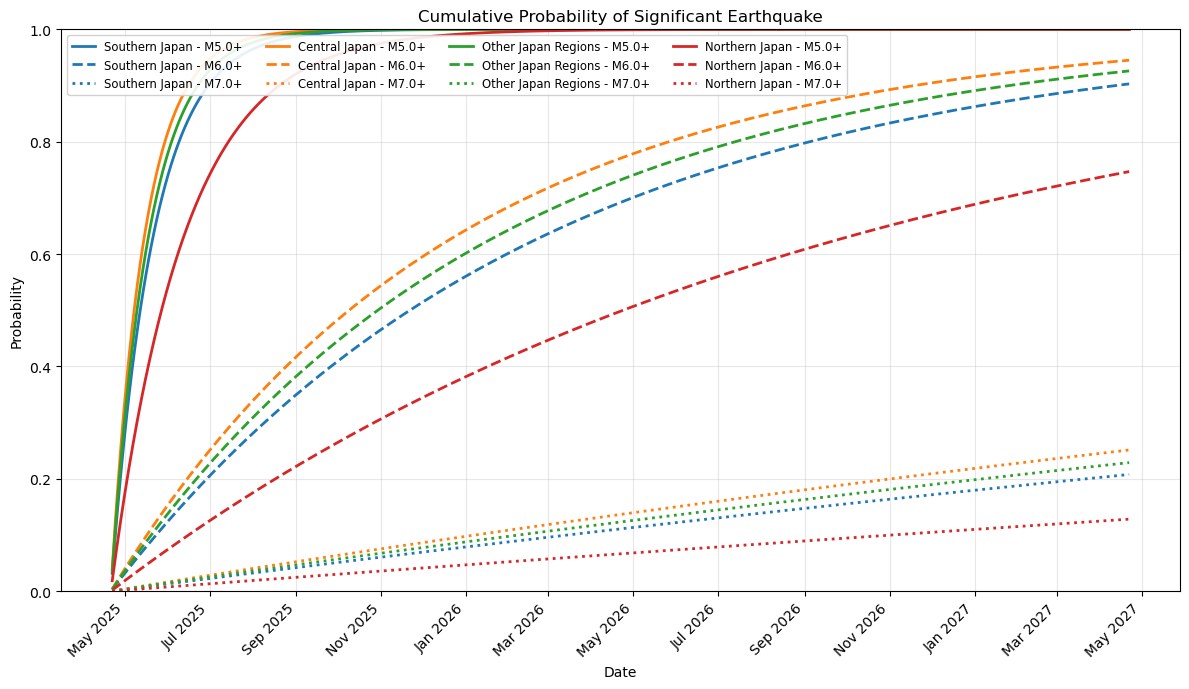

In [257]:
probability_results = plot_earthquake_probabilities(hawkes_results, EQ_clean)

# To access the probability table as a DataFrame:
prob_table = probability_results['probability_table']

In [259]:
probability_results['plot'].savefig('JPearthquake_probabilities.png', dpi=300)